## Setup

The relation between density and the gravity field is well known, thanks to the classic work of Newton in 1686. Since we generally only measure the vertical component of the field, this relationship can be written as:

$$G(r)_z = \gamma \int_{V}   \rho(r) \left(\frac{z - z_0}{{|\vec r - \vec r_0|}^3}\right) \; dV $$

where $\rho$ is the anomalous density and $\gamma$ is the Newton's gravitational constant.
This integral can be evaluated analytically for simple prisms, giving rise to a linear system of equations relating a discrete Earth to the observed data:

$$ \mathbf{d}_z =  \mathbf{F} \; \boldsymbol{\rho} $$



In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from SimPEG import (Mesh, Directives, Maps, 
                    InvProblem, Optimization, DataMisfit, 
                    Inversion, Utils, Regularization)

import SimPEG.PF as PF
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# First we need to define the direction of the inducing field
# As a simple case, we pick a vertical inducing field of magnitude 50,000nT. 
# From old convention, field orientation is given as an azimuth from North 
# (positive clockwise) and dip from the horizontal (positive downward).
H0 = (50000., 90., 0.)

# Assume all induced so the magnetization M is also in the same direction
M = np.array([90,0])

# Create a mesh
h = [5,5,5]
padDist = np.ones((3,2)) * 100

# Create grid of points for topography
# Lets create a simple Gaussian topo and set the active cells
[xx, yy] = np.meshgrid(np.linspace(-200,200,50), np.linspace(-200,200,50))
b = 100
A = 50
zz = A*np.exp(-0.5*((xx/b)**2. + (yy/b)**2.))

# We would usually load a topofile
topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy), Utils.mkvc(zz)]

# Create and array of observation points
xr = np.linspace(-100., 100., 20)
yr = np.linspace(-100., 100., 20)
X, Y = np.meshgrid(xr, yr)
Z = A*np.exp(-0.5*((X/b)**2. + (Y/b)**2.)) + 5

# Create a MAGsurvey
xyzLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = PF.BaseGrav.RxObs(xyzLoc)
srcField = PF.BaseGrav.SrcField([rxLoc])
survey = PF.BaseGrav.LinearSurvey(srcField)
survey = PF.BaseGrav.LinearSurvey(srcField) 

# Create a topography
mesh = Utils.modelutils.meshBuilder(topo, h, padDist,
                                    meshType='TREE',
                                    verticalAlignment='center')

# Refine the mesh around topography
mesh = Utils.modelutils.refineTree(mesh, topo, dtype='surface',
                                   nCpad=[0, 5, 3], finalize=False)

mesh = Utils.modelutils.refineTree(mesh, xyzLoc, dtype='surface',
                                   nCpad=[2, 0, 0], finalize=True)


# Define an active cells from topo
actv = Utils.surface2ind_topo(mesh, topo)
nC = int(actv.sum())
Mesh.TreeMesh.writeUBC(mesh, 'OctreeMesh.msh',
                               models={'ActiveOctree.dat': actv})

128 5 320.0 [-317.5        -317.5        -292.08372367]


In [4]:
# Here how the topo looks with a quick interpolation, just a Gaussian...
# tri = sp.spatial.Delaunay(topo)

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.plot_trisurf(topo[:,0], topo[:,1], topo[:,2], triangles=tri.simplices, cmap=plt.cm.Spectral)
# ax.scatter3D(xyzLoc[:,0],xyzLoc[:,1],xyzLoc[:,2], c='k')
# ax.set_aspect(1./4)
# plt.show()



Now that we have all our spatial components, we can create our linear system. For a single location and single component of the data, the system would looks like this:

$$ b_x =
	\begin{bmatrix}
	T_{xx}^1 &... &T_{xx}^{nc} & T_{xy}^1 & ... & T_{xy}^{nc} & T_{xz}^1 & ... & T_{xz}^{nc}\\
	 \end{bmatrix}
	 \begin{bmatrix}
		\mathbf{M}_x \\ \mathbf{M}_y \\ \mathbf{M}_z
	\end{bmatrix} \\ $$

where each of $T_{xx},\;T_{xy},\;T_{xz}$ are [nc x 1] long. For the $y$ and $z$ component, we need the two other rows of the tensor $\mathbf{T}$.
In our simple induced case, the magnetization direction $\mathbf{M_x,\;M_y\;,Mz}$ are known and assumed to be constant everywhere, so we can reduce the size of the system such that: 

$$ \vec{\mathbf{d}}_{\text{pred}} = (\mathbf{T\cdot M})\; \kappa$$



In most geophysical surveys, we are not collecting all three components, but rather the magnitude of the field, or $Total\;Magnetic\;Intensity$ (TMI) data.
Because the inducing field is really large, we will assume that the anomalous fields are parallel to $H_0$:

$$ d^{TMI}  = \hat H_0 \cdot \vec d$$

We then end up with a much smaller system:

$$ d^{TMI} = \mathbf{F\; \kappa}$$

where $\mathbf{F} \in \mathbb{R}^{nd \times nc}$ is our $forward$ operator.

In [6]:
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, np.nan)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP = nC)

# Create the forward model operator
prob = PF.Gravity.GravityIntegral(mesh, rhoMap = idenMap, actInd = actv)

# Pair the survey and problem
survey.pair(prob)



In [7]:
# We can now create a susceptibility model and generate data
# Lets start with a simple block in half-space
# model = Utils.ModelBuilder.addBlock(mesh.gridCC, np.zeros(mesh.nC), np.r_[-40,-40,-50], np.r_[40,40,0], 0.05)[actv]

model = np.zeros(mesh.nC)

# first Block magnetized down towards West
ind = Utils.ModelBuilder.getIndicesBlock(
    np.r_[-20, -20, -10], np.r_[20, 20, 25],
    mesh.gridCC,
)[0]
model[ind] = 0.2

# # Second Block magnetized up towards West
# ind = Utils.ModelBuilder.getIndicesBlock(
#     np.r_[20, -20, -10], np.r_[55, 20, 25],
#     mesh.gridCC,
# )[0]
# model[ind,:] = np.kron(np.ones((ind.shape[0],1)), np.c_[0, 0, -1]*0.05)

# Remove air cells
model = model[actv]

In [8]:
# Compute linear forward operator and compute some data
data = prob.fields(Utils.mkvc(model))

std = 0.001  #mGal
data += np.random.randn(len(data))*std
wd = np.ones(len(data))*std

survey.dobs = data
survey.std = wd

Begin linear forward calculation: z
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Linear forward calculation ended in: 2.652003765106201 sec


<IPython.core.display.Javascript object>


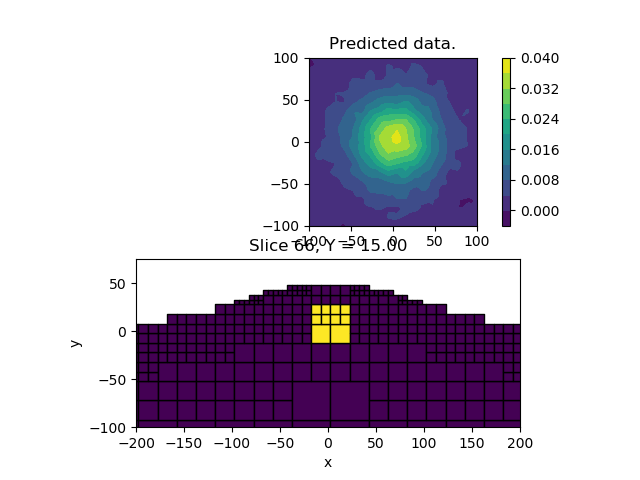

In [9]:
actvPlot = Maps.InjectActiveCells(mesh, actv, np.nan)
# Create a few models
plt.figure()

# We can now generate data
#data = F.dot(model)  #: this is matrix multiplication!!
ax = plt.subplot(2,1,1)
im = Utils.PlotUtils.plot2Ddata(xyzLoc, data, ax=ax)
plt.colorbar(im[0])
ax.set_title('Predicted data.')
plt.gca().set_aspect('equal', adjustable='box')


ax = plt.subplot(2,1,2)
# out = mesh.plotSlice(actvPlot*np.sum(model**2.,axis=1)**0.5, ax = ax, normal = 'Y', ind=66)
mesh.plotSlice(actvPlot*model, ax = ax, normal = 'Y', ind=66, clim=[0.0,.01])
ax.set_xlim([-200,200])
ax.set_ylim([-100,75])
ax.set_xlabel('x');ax.set_ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()




## Inverse problem

We have generated synthetic data, we now want to see if we can solve the inverse problem and recover our synthetic density model. Using the usual formulation, we seek a model that can reproduce the data, let’s say a least-squares measure of data fit of the form:

\begin{equation}
\phi_d =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2
\end{equation}

The inverse problem is hard because we don’t have great data coverage, and the Earth is big, and there is usually noise in the data. So we need to add something to regularize it.
The simplest way to do it is to penalize solutions that won’t make sense geologically. For example we can assume that the model is smooth and that anomalous density should remain small.
The usual smooth inversion function use an l2-norm measure:

\begin{equation}
\phi_d =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2 \\
\phi_m = \beta \Big [ {\| \mathbf{W}_s \;( \mathbf{m - m^{ref}})\|}^2_2  + \sum_{i = x,y,z}  {\|   \mathbf{W}_i  \; \mathbf{G}_i \; \mathbf{m}\|}^2_2  \Big ]\;,
\end{equation}

The full objective function to be minimized can be written as:

\begin{equation}
\phi(m) =  \phi_d + \beta \phi_m\;,
\end{equation}

which will yield our usual *small* and *smooth* models. 

We propose a fancier regularization function that can allow to recover *sparse* and *blocky* solutions.
Starting with the well known Ekblom norm:
\begin{equation}
\phi_m =  \sum_{i=1}^{nc} {(x_i^2 + \epsilon^2)}^{p/2} \;,
\end{equation}
where $x_i$ denotes some function of the model parameter, and $\epsilon$ is a small value to avoid singularity as $m\rightarrow0$.
For p=2, we get the usual least-squares measure and we recover the regularization presented above. For $p \leq 1$, the function becomes non-linear which requires some tweaking.

We can linearize the function by updating the penality function iteratively, commonly known as an Iterative Re-weighted Least-Squares (IRLS) method:

\begin{equation} 
\phi_m^{(k)} =  \frac{1}{2}\sum_{i=1}^{nc} r_i \; x_i^2
\end{equation}

where we added the superscript $\square^{(k)}$ to denote the IRLS iterations. The weights $r(x)$ are computed from model values obtained at a previous iteration such that:

\begin{equation}
	{r}_i  ={\Big( {({x_i}^{(k-1)})}^{2} + \epsilon^2 \Big)}^{p/2 - 1} \;,
\end{equation}

where ${r}(x) \in \mathbb{R}^{nc}$.

In matrix form, our objective function simply becomes:

\begin{equation}
\phi(m) =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2 + \beta \Big [ {\| \mathbf{W}_s \;\mathbf{R}_s\;( \mathbf{m - m^{ref}})\|}^2_2  + \sum_{i = x,y,z}  {\|   \mathbf{W}_i\; \mathbf{R}_i  \; \mathbf{G}_i \; \mathbf{m}\|}^2_2  \Big ]\;,
\end{equation}

where the IRLS weights $\mathbf{R}_s$ and $\mathbf{R}_i$ are diagonal matrices defined as:

\begin{equation}
\begin{split}
	{R}_{s_{jj}}  &=  \sqrt{\eta_p}{\Big[ {({m_j}^{(k-1)})}^{2} + \epsilon_p^2 \Big]}^{(p/2 - 1)/2} \\
	{R}_{i_{jj}}  &=  \sqrt{\eta_q}{\Big[ {\left ({{(G_i\;m^{(k-1)})}_j }\right)}^{2} + \epsilon_q^2 \Big]}^{(q/2 - 1)/2} \\
\eta_p &=  {\epsilon_p}^{(1-p/2)} \\
\eta_q &=   {\epsilon_q}^{(1-q/2)}  \;, 
\end{split}
\end{equation}

we added two scaling parameters $\eta_p$ and $\eta_q$ for reasons that we won't dicuss here, but turn out to be important to get stable solves.

In order to initialize the IRLS and get an estimate for the stabilizing parameters $\epsilon_p$ and $\epsilon_q$, we first invert with the smooth $l_2$-norm. 
The whole IRLS process is implemented with a directive added to the inversion workflow (see below).


In [10]:
# Create sensitivity weights from our linear forward operator
# so that all cells get equal chance to contribute to the solution
wr = np.sum(prob.G**2., axis=0)
wr = (wr/np.max(wr))**0.5


# Create three regularization for the different components
# of magnetization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.norms = np.c_[0, 0, 0, 0]
reg.cell_weights = wr
reg.mref = np.zeros(nC)

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=-1., upper=1.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-4)

invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, maxIRLSiter=20, beta_tol = 5e-1)
update_Jacobi = Directives.UpdatePreconditioner()

saveOuput = Directives.SaveOutputEveryIteration()
# saveModel.fileName = work_dir + out_dir + 'ModelSus'

inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)  * 1e-4# Starting model
mrec = inv.run(m0)


Use Simple
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.43e+09  2.15e+04  1.04e-06  2.51e+04    1.25e+02      0              
   1  1.72e+09  2.29e+04  1.24e-07  2.31e+04    1.25e+02      0              
   2  8.58e+08  2.21e+04  4.59e-07  2.25e+04    1.25e+02      0              
   3  4.29e+08  2.08e+04  1.59e-06  2.15e+04    1.25e+02      0   Skip BFGS  
   4  2.14e+08  1.88e+04  4.97e-06  1.99e+04    1.25e+02      0   Skip BFGS  
   5  1.07e+08  1.64e+04  1.32e-05  1.78e+04    1.25e+02      0   Skip BFGS  
   6  5.36e+07  1.40e+04  2.91e-05  1.56e+04    1.25e+02      0   Skip BFGS  
   7  2.68e+07  1.19e+04  5.68e-05  1.34e+04    1.25

In [11]:
actvMapOut = Maps.InjectActiveCells(mesh, actv, -100)
Mesh.TreeMesh.writeUBC(mesh, 'OctreeMesh.msh',
                               models={'RecMod.dat': actvMapOut*mrec})

<IPython.core.display.Javascript object>


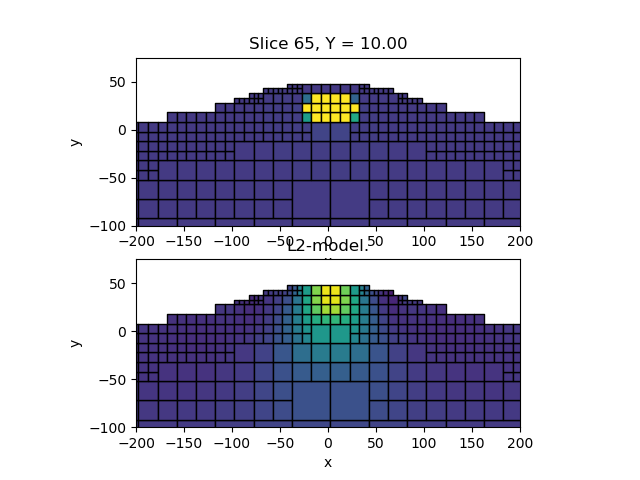

<IPython.core.display.Javascript object>


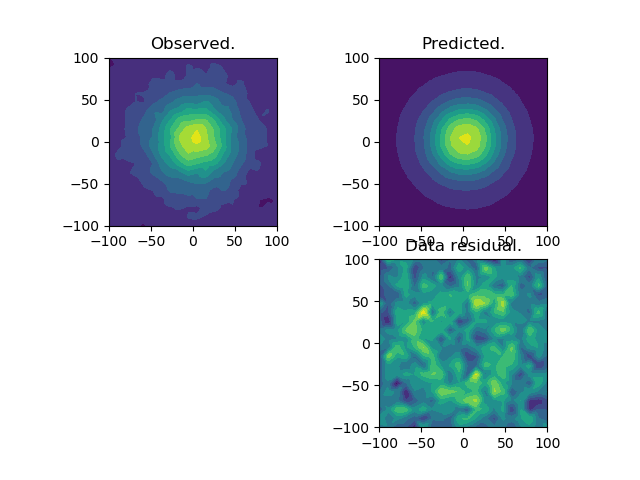

In [12]:
plt.figure()
ax = plt.subplot(2,1,1)
# out = mesh.plotSlice(actvPlot*np.sum(model**2.,axis=1)**0.5, ax = ax, normal = 'Y', ind=66)
mesh.plotSlice(actvPlot*mrec, ax = ax, normal = 'Y', ind=65, clim=[-0.01, 0.05])
ax.set_xlim([-200,200])
ax.set_ylim([-100,75])
# ax.set_title('A simple block model.')
ax.set_xlabel('x');ax.set_ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')

ax = plt.subplot(2,1,2)
# out = mesh.plotSlice(actvPlot*np.sum(model**2.,axis=1)**0.5, ax = ax, normal = 'Y', ind=66)
mesh.plotSlice(actvPlot*invProb.l2model, ax = ax, normal = 'Y', ind=65, clim=[-0.01, 0.05])
ax.set_xlim([-200,200])
ax.set_ylim([-100,75])
ax.set_title('L2-model.')
ax.set_xlabel('x');ax.set_ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')


plt.show()

# We can now generate data
#data = F.dot(model)  #: this is matrix multiplication!!
plt.figure()
ax = plt.subplot(2, 2, 1)
Utils.PlotUtils.plot2Ddata(xyzLoc, survey.dobs, ax=ax)
ax.set_title('Observed.')
plt.gca().set_aspect('equal', adjustable='box')

ax = plt.subplot(2, 2, 2)
Utils.PlotUtils.plot2Ddata(xyzLoc, invProb.dpred, ax=ax)
ax.set_title('Predicted.')
plt.gca().set_aspect('equal', adjustable='box')

ax = plt.subplot(2, 2, 4)
Utils.PlotUtils.plot2Ddata(xyzLoc, data-invProb.dpred, ax=ax)
ax.set_title('Data residual.')
plt.gca().set_aspect('equal', adjustable='box')

Hopefully you now have an idea of how to create a Problem class in SimPEG, and how this can be used with the other tools available.